In [1]:
import numpy as np
import seaborn as sns
from scipy.stats import wilcoxon, mannwhitneyu
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve,

In [5]:
def prc(y_true, y_scores):
    """
    Calculates precision and recall for different thresholds.

    Args:
        y_true (array-like): True binary labels.
        y_scores (array-like): Predicted probabilities or scores.

    Returns:
        precision (array): Precision values for different thresholds.
        recall (array): Recall values for different thresholds.
        thresholds (array): Thresholds used to calculate precision and recall.
    """

    precision, recall, thresholds = [], [], []
    unique_thresholds = np.unique(y_scores)

    for threshold in unique_thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        if tp + fp > 0:
            precision.append(tp / (tp + fp))
        else:
            precision.append(1)

        if tp + fn > 0:
            recall.append(tp / (tp + fn))
        else:
            recall.append(0)

        thresholds.append(threshold)

    return precision, recall, thresholds

def get_max_seqlet_sum(arr, length=10):
    assert arr.shape[-1] - length >= 0
    if arr.shape == 3:
        arr = arr.sum(axis=1)
    sums = []
    for n in range(arr.shape[0]):
        max_score = -np.inf
        for i in range(arr.shape[-1] - length):
            score = arr[n, i:i+length].sum()
            if score > max_score:
                max_score = score
        sums.append(max_score)
    return np.array(sums)

In [6]:
orig=np.load("quantity_pos_patterns_1_uniq_1kb_quantity_shap.npz")["arr_0"]
ms=np.load("quantity_pos_patterns_1_uniq_1kb_motif_shuf_quantity_shap.npz")["arr_0"]
sp_sums = [get_max_seqlet_sum(orig[:, :, 485:515].sum(axis=1)), get_max_seqlet_sum(ms[:, :, 485:515].sum(axis=1))]

In [7]:
orig=np.load("quantity_pos_patterns_8_uniq_1kb_quantity_shap.npz")["arr_0"]
ms=np.load("quantity_pos_patterns_8_uniq_1kb_motif_shuf_quantity_shap.npz")["arr_0"]
irf_sums = [get_max_seqlet_sum(orig[:, :, 485:515].sum(axis=1)), get_max_seqlet_sum(ms[:, :, 485:515].sum(axis=1))]

In [39]:
irf_sums

[array([1.56321939, 2.06102403, 0.86037766, ..., 1.04948994, 1.24728123,
        1.26368603]),
 array([0.10153901, 0.06701904, 0.22380308, ..., 0.10315612, 0.40724182,
        0.00216529])]

In [8]:
print(wilcoxon(*irf_sums))
print(wilcoxon(*sp_sums))

WilcoxonResult(statistic=6417.0, pvalue=8.344975712181456e-197)
WilcoxonResult(statistic=936908.0, pvalue=0.0)


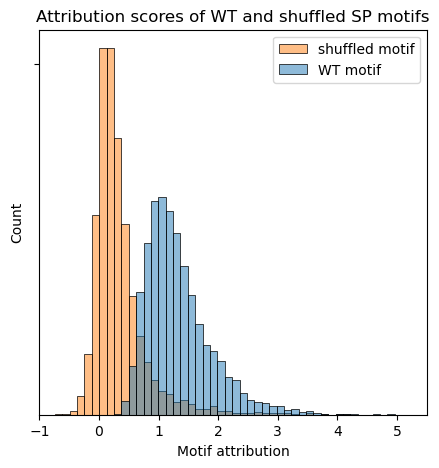

In [61]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

sns.histplot(sp_sums, bins=50)
plt.xlim(-1, 5.5)
plt.yticks([1600])
ax.set_yticklabels([])
plt.xlabel("Motif attribution")
plt.title("Attribution scores of WT and shuffled SP motifs")
plt.legend(["shuffled motif", "WT motif"])
plt.savefig("img/motif_shuffle_hist_sp.pdf")

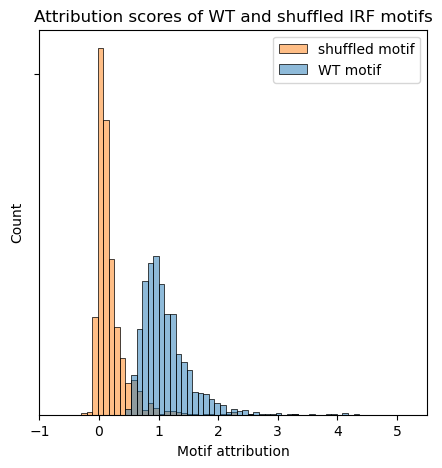

In [60]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
sns.histplot(irf_sums, bins=50)
plt.xlim(-1, 5.5)
plt.yticks([350])
ax.set_yticklabels([])
plt.xlabel("Motif attribution")
plt.title("Attribution scores of WT and shuffled IRF motifs")
plt.legend(["shuffled motif", "WT motif"])
plt.savefig("img/motif_shuffle_hist_irf.pdf")

In [18]:
irf = pd.DataFrame(
    {
        "labels": [True] * irf_sums[0].shape[0] + [False] * irf_sums[1].shape[0],
        "attr": np.concatenate(irf_sums)
    }
)
sp = pd.DataFrame(
    {
        "labels": [True] * sp_sums[0].shape[0] + [False] * sp_sums[1].shape[0],
        "attr": np.concatenate(sp_sums)
    }
)
random = pd.DataFrame(
    {
        "labels": [True] * irf_sums[0].shape[0] + [False] * irf_sums[1].shape[0],
        "attr": np.random.rand(irf_sums[0].shape[0] + irf_sums[1].shape[0])
    }
)

In [19]:
# Compute precision and recall
irf_prc = prc(irf.labels, irf.attr)
sp_prc = prc(sp.labels, sp.attr)
random_prc = prc(random.labels, random.attr)

# Compute fpr, tpr
irf_roc = roc_curve(irf.labels, irf.attr)
sp_roc = roc_curve(sp.labels, sp.attr)
random_roc = roc_curve(random.labels, random.attr)

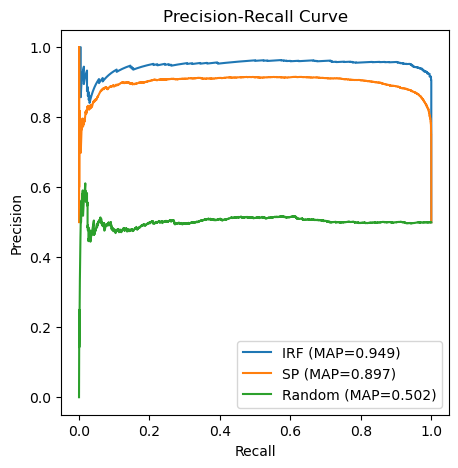

In [30]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot Precision-Recall Curve
plt.plot(irf_prc[1], irf_prc[0])
plt.plot(sp_prc[1], sp_prc[0])
plt.plot(random_prc[1], random_prc[0])
#plt.ylim(0.2, 1.05)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(
    [
        f"IRF (MAP={average_precision_score(irf.labels, irf.attr):.3f})",
        f"SP (MAP={average_precision_score(sp.labels, sp.attr):.3f})",
        f"Random (MAP={average_precision_score(random.labels, random.attr):.3f})"
    ]
)
plt.savefig("img/motif_shuffle_prc.pdf")

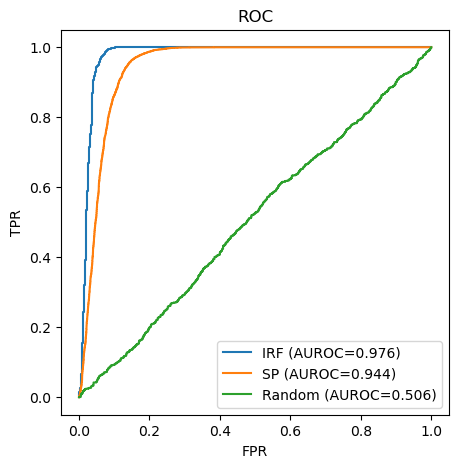

In [31]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot Precision-Recall Curve
plt.plot(irf_roc[0], irf_roc[1])
plt.plot(sp_roc[0], sp_roc[1])
plt.plot(random_roc[0], random_roc[1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend(
    [
        f"IRF (AUROC={roc_auc_score(irf.labels, irf.attr):.3f})",
        f"SP (AUROC={roc_auc_score(sp.labels, sp.attr):.3f})",
        f"Random (AUROC={roc_auc_score(random.labels, random.attr):.3f})"
    ]
)
plt.savefig("img/motif_shuffle_roc.pdf")

0.8973642461905743